**Instituto de Informática - UFG**

Disciplina: Inteligência Artificial

Prof. Cedric Luiz de Carvalho

Grupo número (   )

---


Aluna(o): 

---

Aluna(o): 

---

Aluna(o): 

---

# Especificação do problema : Árvores de Decisão

A partir da base de dados disponibilizada anteriormente, induzir uma árvore de decisão que correlacione o desempenho nos dois primeiros períodos do curso com um bom desempenho final e permita fazer previsões sobre o desempenho final de novos alunos.

Para isso, considere:


1.  Um aluno com bom desempenho é aquele que se forma em até 4 anos e meio ou se forma com média igual ou superior a 7 ou  se forma com número de reprovações igual inferior a 5.

2. Para o treinamento do modelo, considere apenas as disciplinas dos dois primeiros períodos do curso.

3. Escolher pelo menos um dos seguintes algoritmos para a implementação: ID3, C4.5 e CART.

4. Para visualização das árvores de decisão geradas, utilize o [graphviz](https://towardsdatascience.com/interactive-visualization-of-decision-trees-with-jupyter-widgets-ca15dd312084).


**Observação 1**: Poderão ser utilizados códigos de outros autores, desde que sejam feitos ou devidos créditos aos mesmos. Esses códigos devem ser devidamente comentados.

**Observação 2**: O trabalho deve ser feito em grupo, mas a avaliação será feita individualmente. Para isso, o grupo deverá fazer um planejamento/cronograma de trabalho e o trabalho de cada membro deverá ser devidamente identificado (por meio de** ##NomeDoAluno**)

#Procedimento


Cada membro do grupo deve assumir um dos papéis a seguir:



1.   Gerente do projeto: deve se encarregar de organizar as atividades do projeto, produzir toda a documentação do mesmo, seguindo rigorosamente o padrão definido pelo professor e fazer sua apresentação no momento apropriado.
2.   Analista de dados: deve produzir o conjunto de exemplos necessário para a implementação do modelo, bem como a sua documentação.
3. Desenvolvedor: deve implementar o modelo proposto pelo grupo, seja utilizando códigos de terceiros ou seus próprios códigos.


In [302]:
import pandas as pd
import numpy as np 
import seaborn as sns
import math
from collections import defaultdict
df = pd.read_csv('baseDeDados.csv', sep=';')

/home/user/.conda/envs/tcc/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [86]:
# " Um aluno com bom desempenho é aquele que se forma em até 4 anos e meio"

# Desconsiderar alunos que ingressaram há menos de 4 anos e meio atrás: depois de 2015.1

alunos = df[['id', 'ano_periodo_ingresso', 'data_colacao_grau', 'media_global_atual_discente']].\
rename(columns={'id': 'identificador'})

alunos['reprovacoes'] = 0

cols = ['quantidade_reprovacoes_nc', 'quantidade_reprovacoes_nl', 'quantidade_reprovacoes_neobr', 'quantidade_reprovacoes_neopt']

media_global = df[['id', 'nota_discente_componente']].\
rename(columns={'id': 'identificador'}).\
dropna().\
groupby(by=['identificador']).\
mean().\
rename(columns={'nota_discente_componente': 'media_global_calculada'})

alunos = pd.merge(alunos, media_global, how='outer', on='identificador')

alunos['media_global_considerada'] = alunos['media_global_atual_discente'].\
combine(alunos['media_global_calculada'], lambda x,y: x if not math.isnan(x) else y )

for item in cols:
     alunos['reprovacoes'] += df[item].fillna(0)

alunos['classificacao_1'] = 0
alunos['classificacao_2'] = 0
alunos['classificacao_3'] = 0
alunos['classificacao_final'] = 0

alunos = alunos[alunos['ano_periodo_ingresso'] < 2015.1 ]

alunos['data_colacao_grau'] = alunos['data_colacao_grau'].fillna('0-0-0')

alunos['data_colacao_grau'] = alunos['data_colacao_grau'].\
apply(lambda x: int(x.split('-')[0]) + 0.1 * (int(x.split('-')[1]) < 7) + 0.2 * (int(x.split('-')[1]) > 7)  )

alunos['diff'] = alunos['data_colacao_grau'] - alunos['ano_periodo_ingresso']

alunos['classificacao_1'] = alunos['diff'].\
apply(lambda x: 1 if ( x <= 4.5 and x > 0 ) else 0)

alunos = alunos.drop_duplicates()

# se forma

alunos['formado'] = alunos['diff'].\
apply(lambda x: 1 if x > 0 else 0)

# "se forma E tem média igual ou superior a 7"

alunos['classificacao_2'] = alunos['media_global_considerada'].\
apply(lambda x: 1 if x >= 7 else 0 ).\
combine(alunos['formado'], lambda x,y: 1 if x & y else 0 )

# "se forma E tem número de reprovações igual inferior a 5."

alunos['classificacao_3'] = alunos['reprovacoes'].\
apply(lambda x: 1 if x <= 5 else 0 ).\
combine(alunos['formado'], lambda x,y: 1 if x & y else 0 )

# classificacao final

alunos['classificacao_final'] = alunos['classificacao_1'].\
combine(alunos['classificacao_2'], lambda x,y: 1 if x | y else 0 ).\
combine(alunos['classificacao_3'], lambda x,y: 1 if x | y else 0 )

alunos.sample(10)

,identificador,ano_periodo_ingresso,data_colacao_grau,media_global_atual_discente,reprovacoes,media_global_calculada,media_global_considerada,classificacao_1,classificacao_2,classificacao_3,classificacao_final,diff,formado
3516,90,2009.2,0.1,NaN,6.0,1.457143,1.457143,0,0,0,0,-2009.1,0
12996,371,2012.2,0.1,4.98,30.0,4.850000,4.980000,0,0,0,0,-2012.1,0
2195,57,2009.2,2017.2,5.48,23.0,5.443548,5.480000,0,0,0,0,8.0,1
15398,444,2013.1,0.1,3.84,2.0,3.550000,3.840000,0,0,0,0,-2013.0,0
12281,352,2012.2,2017.2,6.83,9.0,6.878000,6.830000,0,0,0,0,5.0,1
3397,85,2009.1,0.1,5.14,19.0,0.983333,5.140000,0,0,0,0,-2009.0,0
5045,134,2009.1,0.1,NaN,0.0,8.000000,8.000000,0,0,0,0,-2009.0,0
1136,29,2008.1,2011.1,NaN,1.0,7.531034,7.531034,1,1,1,1,3.0,1
3209,80,2009.1,2013.2,NaN,16.0,5.482456,5.482456,1,0,0,1,4.1,1
5819,159,2010.2,2018.2,4.60,46.0,4.527586,4.600000,0,0,0,0,8.0,1


In [303]:
alunos[['identificador', 'classificacao_final']].head()

,identificador,classificacao_final
0,1,0
56,2,1
96,3,1
142,4,0
190,5,1


In [235]:
# "Para o treinamento do modelo, considere apenas as disciplinas dos dois primeiros períodos do curso."

disciplinas = df[['matriz_semestre_previsto_cursar_compomente', 'nome_componente']].\
drop_duplicates().\
rename(columns={'matriz_semestre_previsto_cursar_compomente': 'semestre_previsto'})

disciplinas['num_semestre'] = disciplinas['semestre_previsto'].\
apply(lambda x: int(x.split('/')[1][0]) )

disciplinas = disciplinas[disciplinas['num_semestre'] <= 2]

# somente da grade antiga
disciplinas = disciplinas[disciplinas['semestre_previsto'].str.contains('CICOMP-BI-2')]

disciplinas

,semestre_previsto,nome_componente,num_semestre
0,CICOMP-BI-2/1-IME0073,CÁLCULO 1,1
1,CICOMP-BI-2/1-INF0131,LÓGICA MATEMÁTICA,1
2,CICOMP-BI-2/1-INF0135,MATEMÁTICA DISCRETA,1
3,CICOMP-BI-2/2-IFI0105,FÍSICA PARA COMPUTAÇÃO,2
4,CICOMP-BI-2/2-IME0006,ÁLGEBRA LINEAR,2
6,CICOMP-BI-2/2-IME0078,CÁLCULO 2,2
7,CICOMP-BI-2/2-INF0157,PROGRAMAÇÃO DE COMPUTADORES 2 CN,2
8,CICOMP-BI-2/2-INF0195,SISTEMAS DIGITAIS,2
58,CICOMP-BI-2/1-INF0109,INTRODUÇÃO À COMPUTAÇÃO,1
60,CICOMP-BI-2/1-INF0156,PROGRAMAÇÃO DE COMPUTADORES 1 CN,1


In [305]:
disciplinas = disciplinas[['nome_componente']]

identificadores = alunos[['identificador']]
notas = pd.merge(df[['id', 'nome_componente', 'nota_discente_componente']].\
                       rename(columns={'id': 'identificador'}),\
                       identificadores, how='outer', on='identificador')
# enumerar linhas repetidas
notas['componente_enum'] = notas[['identificador', 'nome_componente']].\
groupby(by=['identificador', 'nome_componente']).\
cumcount()+1

In [306]:
# Vamos descobrir:
# -- qual a média dos bons alunos que estão fazendo pela primeira vez
# -- qual a média dos bons alunos que estão fazendo pela segunda vez
# -- qual a média dos bons alunos que estão fazendo pela terceira vez
# etc. etc.

identificadores = alunos[['identificador', 'classificacao_final']]
identificadores = identificadores[identificadores['classificacao_final'] == 1][['identificador']]


medias = notas[['identificador','nome_componente','nota_discente_componente','componente_enum']]

medias = \
pd.merge(identificadores, notas, how='outer', on='identificador').\
groupby(by=['nome_componente', 'componente_enum']).\
mean().\
reset_index([0,-1]).\
rename(columns={'nota_discente_componente' : 'media'})

medias 
# Qual porcentagem de bons alunos fizeram essa matéria pela n-ésima vez?

contagem = pd.merge(identificadores, notas, how='outer', on='identificador').\
groupby(by=['nome_componente', 'componente_enum']).\
count().reset_index([0,-1])

porcentagem = contagem.\
groupby('nome_componente').transform(lambda x: x / x.sum() )[['nota_discente_componente']].\
rename(columns={'nota_discente_componente' : 'porcentagem'})

bons_alunos = medias[['nome_componente', 'componente_enum']]
bons_alunos['porcentagem'] = porcentagem['porcentagem']
bons_alunos['media'] = medias['media']

/home/user/.conda/envs/tcc/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [314]:
# Para cada par (matéria, aluno) devemos:
# -- Atribuir um score que é a porcentagem de bons alunos na última repetição da matéria
# -- Atribuir o desvio da nota do aluno em relação à média dos bons alunos naquela repetição
# -- Atribuir 0 ( se for mau aluno) ou 1 ( se for bom aluno )
# ( repetições sem bons alunos são desconsideradas )
# esses atributos serão fornecidos à árvore de decisão

notas.head()

,identificador,nome_componente,nota_discente_componente,componente_enum
0,1,CÁLCULO 1,7.3,1
1,1,LÓGICA MATEMÁTICA,6.8,1
2,1,MATEMÁTICA DISCRETA,5.0,1
3,1,FÍSICA PARA COMPUTAÇÃO,5.0,1
4,1,ÁLGEBRA LINEAR,4.2,1


In [317]:
dados_finais = notas[['identificador', 'nome_componente', 'nota_discente_componente', 'componente_enum']]
dados_finais = pd.merge(dados_finais, disciplinas[['nome_componente']], how='inner', on='nome_componente')
dados_finais = pd.merge(dados_finais, bons_alunos, how='outer', on=['nome_componente', 'componente_enum']).\
sort_values(by=['identificador', 'nome_componente'])
dados_finais.head(30)

,identificador,nome_componente,nota_discente_componente,componente_enum,porcentagem,media
0,1.0,CÁLCULO 1,7.3,1,0.747051,3.745614
3572,1.0,CÁLCULO 2,5.2,1,0.590051,3.730523
2018,1.0,FÍSICA PARA COMPUTAÇÃO,5.0,1,0.699690,4.177434
763,1.0,LÓGICA MATEMÁTICA,6.8,1,0.754608,4.434656
1631,1.0,MATEMÁTICA DISCRETA,5.0,1,0.953488,6.062602
4155,1.0,PROGRAMAÇÃO DE COMPUTADORES 2 CN,6.0,1,0.787565,6.193202
4734,1.0,SISTEMAS DIGITAIS,6.3,1,0.696581,5.095706
2664,1.0,ÁLGEBRA LINEAR,4.2,1,0.557269,3.194269
3170,1.0,ÁLGEBRA LINEAR,6.9,2,0.258811,3.400426
1,2.0,CÁLCULO 1,4.0,1,0.747051,3.745614


In [342]:
repeticoes = dados_finais.\
groupby(by=['identificador', 'nome_componente']).count().reset_index([0,-1]).\
rename(columns={'nota_discente_componente':'repeticoes'})\
[['identificador', 'nome_componente', 'repeticoes']]

resultado = pd.merge(repeticoes, dados_finais, how='outer', on=['identificador', 'nome_componente']).\
groupby(by=['identificador', 'nome_componente', 'repeticoes']).\
min().\
reset_index([0,-1])

resultado['desvio'] = resultado['nota_discente_componente'] - resultado['media']
resultado['desvio'] += 10
resultado['desvio'] /= 20

resultado['componente'] = resultado.index

resultado = resultado[['identificador', 'componente', 'porcentagem', 'desvio']].\
sort_values(by=['identificador', 'componente']).\
reset_index()\
[['identificador', 'componente', 'porcentagem', 'desvio']]

disc = disciplinas.rename(columns={'nome_componente': 'componente'})

resultado = pd.merge(resultado, disc, how='inner', on='componente').\
sort_values(by=['identificador', 'componente']).\
astype({'identificador' : int})

resultado = pd.merge(resultado, disc, how='outer', on='componente').\
sort_values(by=['identificador', 'componente'])

resultado.head(30)

# verificar valores vazios / desconhecidos 

check_disc = [ x['componente'] for x in list(disc.T.to_dict().values()) ]

check_ids = [ x['identificador'] for x in list(resultado.T.to_dict().values())]

check_ids = [ v for i,v in enumerate(check_ids) if check_ids.index(v) == i ]

table = []
for idx in check_ids:
    for d in check_disc:
        row = {}
        row['identificador'] = idx
        row['componente'] = d
        table.append(row)
        
resultado = pd.merge( pd.DataFrame(table), resultado, how='outer', on=['identificador', 'componente']).\
sort_values(by=['identificador', 'componente'])

# colocar a classificação como coluna

resultado = \
pd.merge(resultado, alunos[['identificador', 'classificacao_final']], how='inner', on='identificador').\
sort_values(by=['identificador', 'componente'])

resultado.head(35)

,componente,identificador,porcentagem,desvio,classificacao_final
0,CÁLCULO 1,1,0.747051,0.677719,0
1,CÁLCULO 2,1,0.590051,0.573474,0
2,FÍSICA PARA COMPUTAÇÃO,1,0.699690,0.541128,0
3,INTRODUÇÃO À COMPUTAÇÃO,1,NaN,NaN,0
4,LÓGICA MATEMÁTICA,1,0.754608,0.618267,0
5,MATEMÁTICA DISCRETA,1,0.953488,0.446870,0
6,PROGRAMAÇÃO DE COMPUTADORES 1 CN,1,NaN,NaN,0
7,PROGRAMAÇÃO DE COMPUTADORES 2 CN,1,0.787565,0.490340,0
8,SISTEMAS DIGITAIS,1,0.696581,0.560215,0
9,ÁLGEBRA LINEAR,1,0.258811,0.550287,0


In [363]:
lista_porcentagem = list(resultado['porcentagem'])
lista_desvio = list(resultado['desvio'])

lista_porcentagem = [ lista_porcentagem[i:i+10] for i in range(0,len(lista_porcentagem),10) ]
lista_desvio = [ lista_desvio[i:i+10] for i in range(0,len(lista_desvio),10) ]

lista_classificacao = list(resultado['classificacao_final'])
lista_classificacao = [ lista_classificacao[i] for i in range(0,len(lista_classificacao),10) ]

assert( len(lista_desvio) == len(lista_porcentagem) == len(lista_classificacao))

features = []
for i,v in enumerate(lista_porcentagem):
    row = []
    row.extend(lista_porcentagem[i])
    row.extend(lista_desvio[i])
    features.append(row)

for idx,item in enumerate(features):
    item.append(lista_classificacao[idx])
    
pd.DataFrame(features).head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.747051,0.590051,0.699690,NaN,0.754608,0.953488,NaN,0.787565,0.696581,0.258811,...,0.573474,0.541128,NaN,0.618267,0.44687,NaN,0.490340,0.560215,0.550287,0
1,0.193971,0.590051,0.699690,0.877168,0.754608,NaN,0.67891,0.787565,0.213675,0.557269,...,0.768474,0.711128,0.601417,0.628267,NaN,0.536911,0.690340,0.427533,0.700287,1
2,0.193971,0.590051,0.218266,0.877168,0.754608,NaN,0.67891,0.787565,0.213675,0.258811,...,0.568474,0.571348,0.586417,0.573267,NaN,0.631911,0.690340,0.472533,0.485287,1
3,0.193971,0.590051,0.699690,0.877168,0.754608,NaN,0.67891,0.046632,0.056980,0.111233,...,0.563474,0.541128,0.486417,0.538267,NaN,0.536911,0.259111,0.382533,0.350287,0
4,0.193971,0.590051,0.699690,0.877168,0.754608,NaN,0.67891,0.787565,0.213675,0.557269,...,0.628474,0.626128,0.486417,0.583267,NaN,0.596911,0.655340,0.442533,0.640287,1


<IPython.core.display.Javascript object>


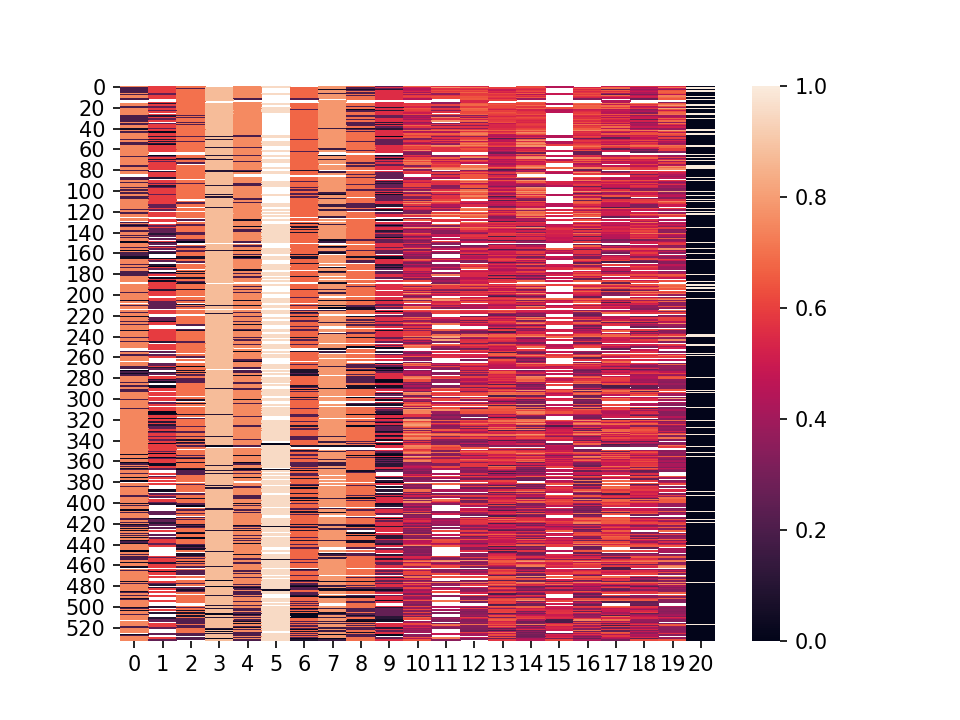

In [365]:
%matplotlib notebook
sns.heatmap(pd.DataFrame(features))